# Deploy and monitor a machine learning workflow for Image Classification

## Setting up this notebook

Notes about the instance size and kernel setup: this notebook has been tested on

1. The `Python 3 (Data Science)` kernel
2. The `ml.t3.medium` Sagemaker notebook instance

## Data Staging

We'll use a sample dataset called CIFAR to simulate the challenges Scones Unlimited are facing in Image Classification. In order to start working with CIFAR we'll need to:

1. Extract the data from a hosting service
2. Transform it into a usable shape and format
3. Load it into a production system

In other words, we're going to do some simple ETL!

### 1. Extract the data from the hosting service

In the cell below, define a function `extract_cifar_data` that extracts python version of the CIFAR-100 dataset. The CIFAR dataaset is open source and generously hosted by the University of Toronto at: https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz 

In [23]:
import requests

def extract_cifar_data(url, filename="cifar.tar.gz"):
    """A function for extracting the CIFAR-100 dataset and storing it as a gzipped file
    
    Arguments:
    url      -- the URL where the dataset is hosted
    filename -- the full path where the dataset will be written
    
    """
    
    # Request the data from the data url
    r = requests.get(url)
    with open(filename, "wb") as file_context:
        file_context.write(r.content)
    return

Let's test it out! Run the following cell and check whether a new file `cifar.tar.gz` is created in the file explorer.

In [24]:
extract_cifar_data("https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz")     

### 2. Transform the data into a usable shape and format

Clearly, distributing the data as a gzipped archive makes sense for the hosting service! It saves on bandwidth, storage, and it's a widely-used archive format. In fact, it's so widely used that the Python community ships a utility for working with them, `tarfile`, as part of its Standard Library. Execute the following cell to decompress your extracted dataset:

In [25]:
import tarfile

with tarfile.open("cifar.tar.gz", "r:gz") as tar:
    tar.extractall()

A new folder `cifar-100-python` should be created, containing `meta`, `test`, and `train` files. These files are `pickles` and the [CIFAR homepage](https://www.cs.toronto.edu/~kriz/cifar.html) provides a simple script that can be used to load them. We've adapted the script below for you to run:

In [26]:
import pickle
# load file data into notebook dictionary

with open("./cifar-100-python/meta", "rb") as f:
    dataset_meta = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/test", "rb") as f:
    dataset_test = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/train", "rb") as f:
    dataset_train = pickle.load(f, encoding='bytes')

In [27]:
# Feel free to explore the datasets

dataset_train.keys()
dataset_train[b'data']
# dataset_meta[b'fine_label_names']

array([[255, 255, 255, ...,  10,  59,  79],
       [255, 253, 253, ..., 253, 253, 255],
       [250, 248, 247, ..., 194, 207, 228],
       ...,
       [248, 240, 236, ..., 180, 174, 205],
       [156, 151, 151, ..., 114, 107, 126],
       [ 31,  30,  31, ...,  72,  69,  67]], dtype=uint8)

As documented on the homepage, `b'data'` contains rows of 3073 unsigned integers, representing three channels (red, green, and blue) for one 32x32 pixel image per row.

In [28]:
32*32*3

3072

For a simple gut-check, let's transform one of our images. Each 1024 items in a row is a channel (red, green, then blue). Each 32 items in the channel are a row in the 32x32 image. Using python, we can stack these channels into a 32x32x3 array, and save it as a PNG file:

In [29]:
import numpy as np

# Each 1024 in a row is a channel (red, green, then blue)
row = dataset_train[b'data'][0]
red, green, blue = row[0:1024], row[1024:2048], row[2048:]

# Each 32 items in the channel are a row in the 32x32 image
red = red.reshape(32,32)
green = green.reshape(32,32)
blue = blue.reshape(32,32)

# Combine the channels into a 32x32x3 image!
combined = np.dstack((red,green,blue))

For a more concise version, consider the following:

In [30]:
# All in one:
test_image = np.dstack((
    row[0:1024].reshape(32,32),
    row[1024:2048].reshape(32,32),
    row[2048:].reshape(32,32)
))

print(test_image.shape)

(32, 32, 3)


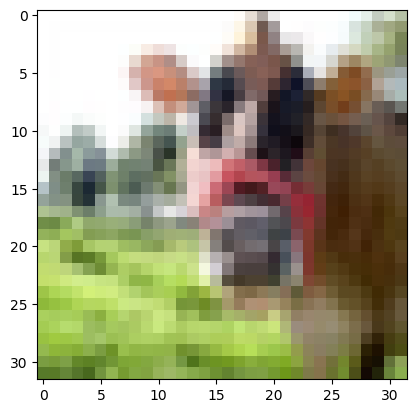

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(test_image);

Looks like a cow! Let's check the label. `dataset_meta` contains label names in order, and `dataset_train` has a list of labels for each row.

In [32]:
dataset_train[b'fine_labels'][0]

19

Our image has a label of `19`, so let's see what the 19th item is in the list of label names.

In [33]:
print(dataset_meta[b'fine_label_names'][19])

b'cattle'


Ok! 'cattle' sounds about right. By the way, using the previous two lines we can do:

In [34]:
n = 0
print(dataset_meta[b'fine_label_names'][dataset_train[b'fine_labels'][n]])

b'cattle'


Now we know how to check labels, is there a way that we can also check file names? `dataset_train` also contains a `b'filenames'` key. Let's see what we have here:

In [35]:
print(dataset_train[b'filenames'][0])

b'bos_taurus_s_000507.png'


"Taurus" is the name of a subspecies of cattle, so this looks like a pretty reasonable filename. To save an image we can also do:

In [36]:
plt.imsave("file.png", test_image)
print(type(test_image))

<class 'numpy.ndarray'>


Your new PNG file should now appear in the file explorer -- go ahead and pop it open to see!

Now that you know how to reshape the images, save them as files, and capture their filenames and labels, let's just capture all the bicycles and motorcycles and save them. Scones Unlimited can use a model that tells these apart to route delivery drivers automatically.

In the following cell, identify the label numbers for Bicycles and Motorcycles:

In [37]:
import pandas as pd
    
# Filter the dataset_train and dataset_meta objects to find the label numbers for Bicycle and Motorcycles
i = 0

for name in dataset_meta[b'fine_label_names']:
    if name == b'bicycle':
        print("bicycle", i)
    if name == b'motorcycle':
        print("motorcycle", i)
    i = i + 1

# bicycle = 8
# motorcycle = 48

bicycle 8
motorcycle 48


Good job! We only need objects with label 8 and 48 -- this drastically simplifies our handling of the data! Below we construct a dataframe for you, and you can safely drop the rows that don't contain observations about bicycles and motorcycles. Fill in the missing lines below to drop all other rows:

In [38]:
#Construct the dataframe
df_train = pd.DataFrame({
    "filenames": dataset_train[b'filenames'],
    "labels": dataset_train[b'fine_labels'],
    "row": range(len(dataset_train[b'filenames'])),
    # "data": dataset_train[b'data']
})

# Drop all rows from df_train where label is not 8 or 48
df_train = df_train.query("labels == 8 | labels == 48")

# Decode df_train.filenames so they are regular strings
df_train["filenames"] = df_train["filenames"].apply(
    lambda x: x.decode("utf-8")
)


df_test = pd.DataFrame({
    "filenames": dataset_test[b'filenames'],
    "labels": dataset_test[b'fine_labels'],
    "row": range(len(dataset_test[b'filenames']))
})

# Drop all rows from df_test where label is not 8 or 48
df_test = df_test.query("labels == 8 | labels == 48")

# Decode df_test.filenames so they are regular strings
df_test["filenames"] = df_test["filenames"].apply(
    lambda x: x.decode("utf-8")
)

Now that the data is filtered for just our classes, we can save all our images.

In [ ]:
# STOP HERE

In [ ]:
# STOP HERE

In [ ]:
# STOP HERE

In [24]:
!mkdir ./train
!mkdir ./test

mkdir: cannot create directory ‘./train’: File exists
mkdir: cannot create directory ‘./test’: File exists


In the previous sections we introduced you to several key snippets of code:

1. Grabbing the image data:

```python
dataset_train[b'data'][0]
```

2. A simple idiom for stacking the image data into the right shape

```python
import numpy as np
np.dstack((
    row[0:1024].reshape(32,32),
    row[1024:2048].reshape(32,32),
    row[2048:].reshape(32,32)
))
```

3. A simple `matplotlib` utility for saving images

```python
plt.imsave(path+row['filenames'], target)
```

Compose these together into a function that saves all the images into the `./test` and `./train` directories. Use the comments in the body of the `save_images` function below to guide your construction of the function:


In [25]:
# print(df_train)
# print(df_train['row'])
# print(df_train.keys())

In [26]:
# # get image data -> get the data from dataset_train
# dataset_train[b'data'][16]
# # i is the row number of df_train -> get this by...
# i = df_train['row'].iloc[0]
# # get the file name
# name = df_train['filenames'].iloc[0]

# # print(df_train.iloc[0])
# # print(dataset_train[b'data'][0])
# # print(dataset_train.keys())
# # print(df_train['row'].iloc[0])

# row = dataset_train[b'data'][16]
# # target = np.dstack((img[0:1024].reshape(32,32), img[1024:2048].reshape(32,32), img[2048:].reshape(32,32)))


# # # All in one:
# # target = np.dstack((
# #     row[0:1024].reshape(32,32),
# #     row[1024:2048].reshape(32,32),
# #     row[2048:].reshape(32,32)
# # ))
# file = 'test' + '/'
# print(file)

# print(target)
# print("BREAK")

# plt.imshow(target);

# # plt.imsave('don't write test or train here now that those files are populated/'+"file.png", test_image)
# print(test_image)



# name = df_train['filenames'].iloc[0]
# plt.imsave('bike_s_000682.png', target)

# # target should be a <class 'numpy.ndarray'>

    
# # go to the index [row]

In [28]:
def save_images(copy_data, paste_data, path):
# or use the apply function
# iter rows vs iter tuples
    for index in range(len(paste_data)):
    #Grab the image data in row-major form
        row = paste_data['row'].iloc[index]
        img = copy_data[b'data'][row]
    
    # Consolidated stacking/reshaping from earlier
        target = np.dstack((img[0:1024].reshape(32,32), img[1024:2048].reshape(32,32), img[2048:].reshape(32,32)))
        
    # Save the image
        name = paste_data['filenames'].iloc[index]
        plt.imsave(path+'/'+name, target)
    
    # Return any signal data you want for debugging
    return True

## TODO: save ALL images using the save_images function
save_images(dataset_train, df_train, "train")
save_images(dataset_test, df_test, "test")

True

### 3. Load the data

Now we can load the data into S3.

Using the sagemaker SDK grab the current region, execution role, and bucket.

In [39]:
import sagemaker
from sagemaker import get_execution_role

current_session = sagemaker.Session()

bucket = current_session.default_bucket()
print("Default Bucket: {}".format(bucket))

region = 'us-east-1'
print("AWS Region: {}".format(region))

role = get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-388656969977
AWS Region: us-east-1
RoleArn: arn:aws:iam::388656969977:role/service-role/AmazonSageMaker-ExecutionRole-20230714T085295


With this data we can easily sync your data up into S3!

In [40]:
import os

os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./train s3://${DEFAULT_S3_BUCKET}/train/
!aws s3 sync ./test s3://${DEFAULT_S3_BUCKET}/test/

In [41]:
# where could I find this bucket? don't see it in s3

And that's it! You can check the bucket and verify that the items were uploaded.

## Model Training

For Image Classification, Sagemaker [also expects metadata](https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html) e.g. in the form of TSV files with labels and filepaths. We can generate these using our Pandas DataFrames from earlier:

In [42]:
import sagemaker
from sagemaker import get_execution_role

current_session = sagemaker.Session()

bucket = current_session.default_bucket()
print("Default Bucket: {}".format(bucket))

region = 'us-east-1'
print("AWS Region: {}".format(region))

role = get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-388656969977
AWS Region: us-east-1
RoleArn: arn:aws:iam::388656969977:role/service-role/AmazonSageMaker-ExecutionRole-20230714T085295


In [43]:
def to_metadata_file(df, prefix):
    df["s3_path"] = df["filenames"]
    df["labels"] = df["labels"].apply(lambda x: 0 if x==8 else 1)
    return df[["row", "labels", "s3_path"]].to_csv(
        f"{prefix}.lst", sep="\t", index=False, header=False
    )
    
to_metadata_file(df_train.copy(), "train")
to_metadata_file(df_test.copy(), "test")

We can also upload our manifest files:

In [44]:
import boto3

# Upload files
boto3.Session().resource('s3').Bucket(
    bucket).Object('train.lst').upload_file('./train.lst')
boto3.Session().resource('s3').Bucket(
    bucket).Object('test.lst').upload_file('./test.lst')

Using the `bucket` and `region` info we can get the latest prebuilt container to run our training job, and define an output location on our s3 bucket for the model. Use the `image_uris` function from the SageMaker SDK to retrieve the latest `image-classification` image below:

In [45]:
# Use the image_uris function to retrieve the latest 'image-classification' image 
algo_image = sagemaker.image_uris.retrieve('image-classification', region)
s3_output_location = f"s3://{bucket}/models/image_model"

We're ready to create an estimator! Create an estimator `img_classifier_model` that uses one instance of `ml.p3.2xlarge`. Ensure that y ou use the output location we defined above - we'll be referring to that later!

In [25]:
img_classifier_model=sagemaker.estimator.Estimator(
    ## Define your estimator options    
    image_uri=algo_image,
    role=role,
    instance_count=1,
    instance_type='ml.p3.2xlarge',
    sagemaker_session=current_session,
    output_path=s3_output_location
)

We can also set a few key hyperparameters and define the inputs for our model:

In [27]:
img_classifier_model.set_hyperparameters(
    image_shape='3,32,32',
    num_classes=2,
    num_training_samples=1000
)

The `image-classification` image uses four input channels with very specific input parameters. For convenience, we've provided them below:

In [28]:
from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput
model_inputs = {
        "train": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/train/",
            content_type="application/x-image"
        ),
        "validation": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/test/",
            content_type="application/x-image"
        ),
        "train_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/train.lst",
            content_type="application/x-image"
        ),
        "validation_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/test.lst",
            content_type="application/x-image"
        )
}

Great, now we can train the model using the model_inputs. In the cell below, call the `fit` method on our model,:

In [29]:
## TODO: train your model
img_classifier_model.fit(model_inputs)

# ensure there is only one execution role and that one has all the permissions
# find the s3 bucket that has stored all the data

INFO:sagemaker:Creating training-job with name: image-classification-2023-07-19-13-11-59-650


2023-07-19 13:11:59 Starting - Starting the training job...
2023-07-19 13:12:26 Starting - Preparing the instances for training.........
2023-07-19 13:14:00 Downloading - Downloading input data
2023-07-19 13:14:00 Training - Downloading the training image..................
2023-07-19 13:17:01 Training - Training image download completed. Training in progress.....Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Wed Jul 19 13:17:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|              

If all goes well, you'll end up with a model topping out above `.8` validation accuracy. With only 1000 training samples in the CIFAR dataset, that's pretty good. We could definitely pursue data augmentation & gathering more samples to help us improve further, but for now let's proceed to deploy our model.

### Getting ready to deploy

To begin with, let's configure Model Monitor to track our deployment. We'll define a `DataCaptureConfig` below:

In [33]:
from sagemaker.model_monitor import DataCaptureConfig

## Set config options
data_capture_config = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=100,
    destination_s3_uri=f"s3://{bucket}/data_capture"
)

Note the `destination_s3_uri` parameter: At the end of the project, we can explore the `data_capture` directory in S3 to find crucial data about the inputs and outputs Model Monitor has observed on our model endpoint over time.

With that done, deploy your model on a single `ml.m5.xlarge` instance with the data capture config attached:

In [34]:
deployment = img_classifier_model.deploy(
    ## TODO: fill in deployment options
    initial_instance_count=1,
    instance_type='ml.m5.xlarge',
    data_capture_config=data_capture_config
    )

endpoint = deployment.endpoint_name
print(endpoint)

INFO:sagemaker:Creating model with name: image-classification-2023-07-19-13-23-23-445
INFO:sagemaker:Creating endpoint-config with name image-classification-2023-07-19-13-23-23-445
INFO:sagemaker:Creating endpoint with name image-classification-2023-07-19-13-23-23-445


---------!image-classification-2023-07-19-13-23-23-445


Note the endpoint name for later as well.

Next, instantiate a Predictor:

In [35]:
predictor = sagemaker.predictor.Predictor(
    endpoint_name=endpoint,
    sagemaker_session=current_session # don't actually need current session
)

In the code snippet below we are going to prepare one of your saved images for prediction. Use the predictor to process the `payload`.

In [36]:
from sagemaker.serializers import IdentitySerializer
import base64

predictor.serializer = IdentitySerializer("image/png")
with open("./test/bicycle_s_001789.png", "rb") as f:
    payload = f.read()

## Process the payload with your predictor
inference = predictor.predict(payload)

Your `inference` object is an array of two values, the predicted probability value for each of your classes (bicycle and motorcycle respectively.) So, for example, a value of `b'[0.91, 0.09]'` indicates the probability of being a bike is 91% and being a motorcycle is 9%.

In [38]:
print(inference)

b'[0.8601636290550232, 0.1398364007472992]'


In [129]:
# Run this if done with coding
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: image-classification-2023-07-19-13-23-23-445
INFO:sagemaker:Deleting endpoint with name: image-classification-2023-07-19-13-23-23-445


In [46]:
import random
import boto3
import json


def generate_test_case():
    # Setup s3 in boto3
    s3 = boto3.resource('s3')
    
    # Randomly pick from sfn or test folders in our bucket
    objects = s3.Bucket(bucket).objects.filter(Prefix="test", )
    
    # Grab any random object key from that folder!
    obj = random.choice([x.key for x in objects])
    
    return json.dumps({
        "image_data": "",
        "s3_bucket": bucket,
        "s3_key": obj
    })
generate_test_case()

'{"image_data": "", "s3_bucket": "sagemaker-us-east-1-388656969977", "s3_key": "test/safety_bicycle_s_001575.png"}'

In the Step Function dashboard for your new function, you can create new executions and copy in the generated test cases. Do several executions so that you can generate data you can evaluate and visualize.

Once you've done several executions, let's visualize the record of our inferences. Pull in the JSONLines data from your inferences like so:

In [47]:
from sagemaker.s3 import S3Downloader

# In S3 your data will be saved to a datetime-aware path
# Find a path related to a datetime you're interested in
data_path = f's3://{bucket}/data_capture/image-classification-2023-07-20-21-44-49-505/AllTraffic/2023/07/20/21' ## Fill in the path to your captured data

S3Downloader.download(data_path, "captured_data")

# Feel free to repeat this multiple times and pull in more data

['captured_data/image-classification-2023-07-17-14-18-31-150/AllTraffic/2023/07/17/14/24-07-630-af7ba644-8eff-493e-b29a-bf1841e20252.jsonl',
 'captured_data/image-classification-2023-07-19-02-06-17-905/AllTraffic/2023/07/19/02/17-46-157-5162a8d9-feb8-4812-a4bd-4e9215cff2f3.jsonl',
 'captured_data/image-classification-2023-07-19-02-18-44-456/AllTraffic/2023/07/19/02/28-11-047-bee3d71c-be7f-477f-a61b-17d472f644d7.jsonl',
 'captured_data/image-classification-2023-07-19-13-23-23-445/AllTraffic/2023/07/19/13/28-47-230-90c51341-7360-44c2-b76c-266effee5458.jsonl',
 'captured_data/image-classification-2023-07-19-13-23-23-445/AllTraffic/2023/07/19/13/30-45-888-a2516adb-35ab-457d-abe4-555b8451a50e.jsonl',
 'captured_data/image-classification-2023-07-19-13-23-23-445/AllTraffic/2023/07/19/14/25-54-688-a79be8f4-d747-4c32-8ac7-e44dc3156d67.jsonl',
 'captured_data/image-classification-2023-07-19-13-23-23-445/AllTraffic/2023/07/19/14/52-21-831-7b084f86-8bb5-4aa8-9d44-041e38954e8f.jsonl',
 'captured_da

The data are in JSONLines format, where multiple valid JSON objects are stacked on top of eachother in a single `jsonl` file. We'll import an open-source library, `jsonlines` that was purpose built for parsing this format.

In [48]:
!pip install jsonlines
import jsonlines


[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: pip install --upgrade pip


Now we can extract the data from each of the source files:

In [56]:
import os

# List the file names we downloaded
file_handles = os.listdir("./captured_data")
# print(file_handles)

# temp = file_handles
# index = 0

# for file in temp:
#     if file[0] == 'i':
#         print(file_handles[index])
#         del file_handles[index]
#     index = index + 1
    
# print(file_handles)

index = 0
image_indicies = []
for file in file_handles:
    if file[-1] != 'l':
        image_indicies.append(index)
        index -= 1
    index += 1

# print(image_indicies)

for image_index in image_indicies:
    del file_handles[image_index]
    
print(file_handles)


# Dump all the data into an array
json_data = []
mypath = "./captured_data"
# for (dirpath, dirnames, filenames) in os.walk(mypath):
#     if len(filenames) > 0:
#         for name in filenames:
#             with jsonlines.open(f"./captured_data/{jsonl}") as f:
#                 json_data.append(f.read())


for jsonl in file_handles:
    with jsonlines.open(f"./captured_data/{jsonl}") as f:
        json_data.append(f.read())

['30-45-888-a2516adb-35ab-457d-abe4-555b8451a50e.jsonl', '05-53-857-2321670f-f61d-48bf-87ef-dca814385555.jsonl', '28-47-230-90c51341-7360-44c2-b76c-266effee5458.jsonl', '08-31-011-9b8d82fd-cf2e-4ccd-9a06-1322589b9dc7.jsonl', '11-23-308-379b6905-20d6-4ab0-9f97-147a21cd6cfa.jsonl', '10-05-450-5b758280-bcf0-43e5-8120-3d2909808a14.jsonl']


The data should now be a list of dictionaries, with significant nesting. We'll give you an example of some code that grabs data out of the objects and visualizes it:

In [61]:
# Define how we'll get our data
def simple_getter(obj):
    inferences = obj["captureData"]["endpointOutput"]["data"]
    timestamp = obj["eventMetadata"]["inferenceTime"]
    return json.loads(inferences), timestamp

simple_getter(json_data[2])

([0.8601636290550232, 0.1398364007472992], '2023-07-19T13:28:47Z')

Finally, here's an example of a visualization you can build with this data. In this last part, you will take some time and build your own - the captured data has the input images, the resulting inferences, and the timestamps.

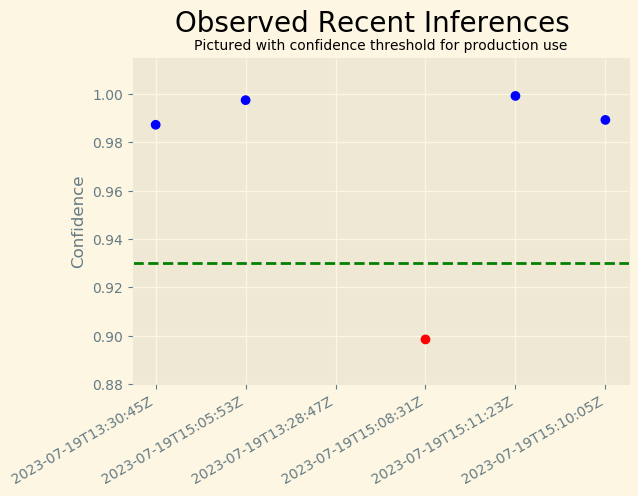

In [102]:
# Populate the data for the x and y axis
x = []
y = []

# confidence and classification
for obj in json_data:
    inference, timestamp = simple_getter(obj)
    # y.append(max(inference))
    # x.append(timestamp)
    if (inference[0] > .93):
        y.append(inference[0])
        x.append("Bicycle")
    elif (inference[1] > .93):
        y.append(inference[1])
        x.append("Motorcycle")
    elif (inference[0] > .88):
        y.append(inference[0])
        x.append("Not Confident Bicycle")
    elif (inference[1] > .88):
        y.append(inference[1])
        x.append("Not Confident Motorcycle")
    elif (inference[0] < .88):
        y.append(.88)
        x.append("Not Confident Bicycle")
    elif (inference[1] > .88):
        y.append(.88)
        x.append("Not Confident Motorcycle")

# Visualization example
# Plot the data
plt.scatter(x, y, c=['r' if k<.93 else 'b' for k in y ])
plt.axhline(y=0.93, color='g', linestyle='--')
plt.ylim(bottom=.88)

# Add labels
plt.ylabel("Confidence")
plt.suptitle("Observed Recent Inferences", size=14)
plt.title("Inference Result and Confidence of Each Inference", size=10)

# Give it some pizzaz!
plt.style.use("Solarize_Light2")
plt.gcf().autofmt_xdate()